# Artificial Neural Networks and Deep Learning



---



## Homework 1: Minimal Working Example



To make your first submission, follow these steps:

1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.

2. Upload the `training_set.npz` file to this folder.

3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.

4. Load and process the data.

5. Implement and train your model.

6. Submit the generated `.zip` file to Codabench.


## ⚙️ Import Libraries

In [1]:
#pip install -U albumentations

In [2]:
import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras_cv.layers as kcv_layers

import albumentations as A

from tensorflow.keras import regularizers


from sklearn.model_selection import train_test_split

import random

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


# Setting mixed precision to speed up computation

#tfk.mixed_precision.set_global_policy("mixed_float16")



seed = 42

np.random.seed(seed)

tf.random.set_seed(seed)


import os

os.listdir('/kaggle/input/')

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


['bloodcells']

## ⏳ Load and inspect the data

In [3]:
data = np.load('/kaggle/input/bloodcells/training_set.npz')

X = data['images']

y = data['labels']



X = (X).astype('float32')

# Convert to one hoot encoding

y = tfk.utils.to_categorical(y)



print('Before data points filter shape:', X.shape, y.shape)



import json

with open('/kaggle/input/bloodcells/blacklist.json', 'r') as file:

	blacklist = json.load(file)

blacklist = sorted(blacklist['blacklist'])

X = np.delete(X, blacklist, axis=0)

y = np.delete(y, blacklist, axis=0)



print('After data points filter shape:', X.shape, y.shape)



train_size = int(X.shape[0] * 0.8)

val_size = int(X.shape[0] * 0.19)

test_size = X.shape[0] - train_size - val_size




X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=val_size, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


# Calcola i pesi delle classi in base alla distribuzione
class_counts = np.bincount(y_train.argmax(axis=1))  # Assumendo y_train one-hot
total = np.sum(class_counts)
class_weights = {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts)}

Before data points filter shape: (13759, 96, 96, 3) (13759, 8)
After data points filter shape: (11959, 96, 96, 3) (11959, 8)
(9567, 96, 96, 3) (2272, 96, 96, 3) (120, 96, 96, 3) (9567, 8) (2272, 8) (120, 8)


In [4]:
# Labels

labels = {

	0: "Basophil",

	1: "Eosinophil",

	2: "Erythroblast",

	3: "Immature granulocytes",

	4: "Lymphocyte",

	5: "Monocyte",

	6: "Neutrophil",

	7: "Platelet"

}

/tmp/ipykernel_30/2406154218.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return labels[int(index)]


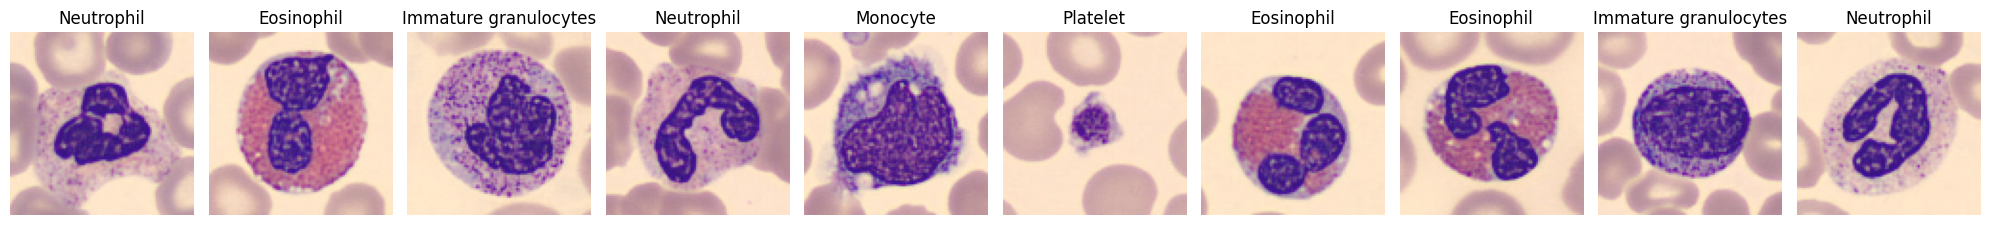

In [5]:
# Inspect data

# Display a sample of images from the training-validation dataset

num_img = 10

random_indices = random.sample(range(len(X_val)), num_img)



fig, axes = plt.subplots(1, num_img, figsize=(20, 20))



def get_label(y):

    index = np.where(y == 1)[0]

    return labels[int(index)]



# Iterate through the selected number of images

for i, idx in enumerate(random_indices):

    ax = axes[i % num_img]

    ax.imshow(np.squeeze(X_val[idx] / 255), vmin=0., vmax=1.)

    ax.set_title(get_label(y_val[idx]))

    ax.axis('off')



# Adjust layout and display the images

plt.tight_layout()

plt.show()

## 🛠️ Train and Save the Model

In [6]:
'''
# Augmentation pipeline
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"), 
    tfkl.RandomRotation(0.3),  
    tfkl.RandomTranslation(0.2, 0.2),  
    tfkl.RandomZoom(0.3),  
    tfkl.RandomContrast(0.3),  
    tfkl.RandomZoom(0.3),  
    tfkl.GaussianNoise(0.1),     
    kcv_layers.RandomSaturation(factor=(0.5,0.7)),               
    kcv_layers.RandomSharpness(factor=(0.0,0.6), value_range=(0, 255)),           
], name='preprocessing1')

augmentation2 = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"), 
    tfkl.RandomRotation(0.3),  
    tfkl.RandomTranslation(0.2, 0.2),   
    tfkl.RandomZoom(0.3), 
    tfkl.RandomBrightness(0.1),                
    kcv_layers.RandomHue(factor=0.2, value_range=(0, 255))
], name='preprocessing2')


# Function to apply augmentations and visualize results
def apply_and_visualize_augmentation(image, transform, num_samples=5):

    plt.figure(figsize=(15, 10))
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(image.astype(np.uint8))
    plt.title("Original Image")
    plt.axis("off")

    image = tf.convert_to_tensor(image, dtype=tf.float32)

    for i in range(num_samples):
        augmented = transform(image)
        #print(f"Augmented image {i+1} pixel range: min={augmented.min()}, max={augmented.max()}")
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow((augmented).numpy().astype(np.uint8))
        plt.title(f"Augmented {i + 1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


for image in X_train[:2]:  # Test on first images
    apply_and_visualize_augmentation(image, augmentation2, num_samples=5)
'''

'\n# Augmentation pipeline\naugmentation = tf.keras.Sequential([\n    tfkl.RandomFlip("horizontal_and_vertical"), \n    tfkl.RandomRotation(0.3),  \n    tfkl.RandomTranslation(0.2, 0.2),  \n    tfkl.RandomZoom(0.3),  \n    tfkl.RandomContrast(0.3),  \n    tfkl.RandomZoom(0.3),  \n    tfkl.GaussianNoise(0.1),     \n    kcv_layers.RandomSaturation(factor=(0.5,0.7)),               \n    kcv_layers.RandomSharpness(factor=(0.0,0.6), value_range=(0, 255)),           \n], name=\'preprocessing1\')\n\naugmentation2 = tf.keras.Sequential([\n    tfkl.RandomFlip("horizontal_and_vertical"), \n    tfkl.RandomRotation(0.3),  \n    tfkl.RandomTranslation(0.2, 0.2),   \n    tfkl.RandomZoom(0.3), \n    tfkl.RandomBrightness(0.1),                \n    kcv_layers.RandomHue(factor=0.2, value_range=(0, 255))\n], name=\'preprocessing2\')\n\n\n# Function to apply augmentations and visualize results\ndef apply_and_visualize_augmentation(image, transform, num_samples=5):\n\n    plt.figure(figsize=(15, 10))\n   

In [18]:
# Define the CutMix layer
cutmix_layer = kcv_layers.CutMix(alpha=1.0, seed=42)

# Augmentation pipeline
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"), 
    tfkl.RandomRotation(0.3),  
    tfkl.RandomTranslation(0.2, 0.2),  
    tfkl.RandomZoom(0.3),  
    tfkl.RandomContrast(0.3),  
    tfkl.RandomZoom(0.3),  
    tfkl.GaussianNoise(0.1),     
    kcv_layers.RandomSaturation(factor=(0.5,0.7)),               
    kcv_layers.RandomSharpness(factor=(0.0,0.6), value_range=(0, 255)),           
], name='preprocessing1')

augmentation2 = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"), 
    tfkl.RandomRotation(0.3),  
    tfkl.RandomTranslation(0.2, 0.2),   
    tfkl.RandomZoom(0.3), 
    tfkl.RandomBrightness(0.3),                
    kcv_layers.RandomHue(factor=0.2, value_range=(0, 255))
], name='preprocessing2')


augmentation3 = A.Compose([
    A.SomeOf([
        A.RandomGamma(gamma_limit=(95,105), p=1.0),
        A.CoarseDropout(max_holes=3, max_height=20, max_width=20, min_holes=1, p=1.0),
    ], n=1, p=1.0)  
])


def apply_aug(images, labels, fractionCM, fractionAUG,fractionAUG2, fractionAUG3):

    assert fractionCM + fractionAUG + fractionAUG2 + fractionAUG3 <= 1, "Fractions must sum to ≤ 1"

    # Shuffle the indices
    shuffled_indices = tf.random.shuffle(tf.range(len(labels)))
    
    # Compute sizes for each subset
    cutmix_size = int(len(labels) * fractionCM)
    aug_size = int(len(labels) * fractionAUG)
    aug2_size = int(len(labels) * fractionAUG2)
    aug3_size = int(len(labels) * fractionAUG3)
    
    # Split the indices
    cutmix_indices = shuffled_indices[:cutmix_size]
    aug_indices = shuffled_indices[cutmix_size:cutmix_size + aug_size]
    aug_indices2 = shuffled_indices[cutmix_size + aug_size:cutmix_size + aug_size + aug2_size]
    aug_indices3 = shuffled_indices[cutmix_size + aug_size + aug2_size:cutmix_size + aug_size + aug2_size + aug3_size]
    
    clean_indices = shuffled_indices[cutmix_size + aug_size + aug2_size + aug3_size:]  # Remaining indices

    # Gather images and labels based on the shuffled indices
    images_cutmix = tf.gather(images, cutmix_indices)
    labels_cutmix = tf.gather(labels, cutmix_indices)

    images_aug = tf.gather(images, aug_indices)
    labels_aug = tf.gather(labels, aug_indices)
    
    images_aug2 = tf.gather(images, aug_indices2)
    labels_aug2 = tf.gather(labels, aug_indices2)

    images_aug3 = tf.gather(images, aug_indices3)
    labels_aug3 = tf.gather(labels, aug_indices3)

    images_clean = tf.gather(images, clean_indices)
    labels_clean = tf.gather(labels, clean_indices)
    
    # Apply augmentations
    #1. Cutmix
    cutmix = cutmix_layer({"images": images_cutmix, "labels": labels_cutmix})
    #2. Augmentation
    augmented = augmentation(images_aug )
    augmented2 = augmentation2(images_aug2)
    #augmented2 = cutmix_layer({"images": images_aug2, "labels": labels_aug2})
    #3. Apply augmentation3
    augmented3 = np.array([augmentation3(image=image.numpy())['image'] for image in images_aug3])
    augmented3 = tf.convert_to_tensor(augmented3)  

    # Concatenate the CutMix and non-CutMix parts back together
    images_combined = tf.concat([cutmix["images"], images_clean, augmented,augmented2, images_cutmix,augmented3], axis=0)
    labels_combined = tf.concat([cutmix["labels"], labels_clean, labels_aug, labels_aug2, labels_cutmix,labels_aug3], axis=0)

    # Shuffle again indices to ensure randomness
    shuffled_indices = tf.random.shuffle(tf.range(len(labels_combined)))
    images_combined = tf.gather(images_combined, shuffled_indices)
    labels_combined = tf.gather(labels_combined, shuffled_indices)
    
    return images_combined, labels_combined

class AugmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size,fractionCM = 0.20, fractionAUG = 0.30,fractionAUG2 = 0.30, fractionAUG3 = 0.20):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.fractionCM = fractionCM
        self.fractionAUG = fractionAUG
        self.fractionAUG2 = fractionAUG2
        self.fractionAUG3 = fractionAUG3

    def __len__(self):
        # Numero di batch per epoca
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        # Ottieni un batch di dati
        batch_images = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]

        # Applica le augmentazioni
        augmented_images, augmented_labels = apply_aug(batch_images, batch_labels, 
                                                        self.fractionCM, self.fractionAUG, self.fractionAUG2, self.fractionAUG3)
        '''
        # Mostra i primi num_images immagini
        num_images = 10
        plt.figure(figsize=(15, 5))
        for i in range(min(num_images, len(augmented_images))):
            plt.subplot(1, num_images, i + 1)
            plt.imshow((augmented_images[i]).numpy().astype(np.uint8))
            plt.axis('off')
        plt.show()
        '''
        return augmented_images, augmented_labels

    
# need to convert it for cutmix
#X_train = tf.convert_to_tensor(X_train, dtype=tf.float32) 
#y_train = y_train.astype('float32')
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32) 
batch_size = 64
train_generator = AugmentationGenerator(X_train, y_train, batch_size=batch_size)


In [9]:
# Initialise imageNet model with pretrained weights, for transfer learning
'''
efficientNetV2 = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=X_train[0].shape,
    pooling='avg',
    classes=len(labels),
    classifier_activation="softmax",
    #name="vgg19",
)
'''

efficientNetV2 = tfk.applications.EfficientNetV2L(

    include_top=False,

    weights="imagenet",

    input_tensor=None,

    input_shape=X_train[0].shape,

    classes=len(labels),

    pooling='avg',

    include_preprocessing=True,

    #name="efficientnetv2-l",

)


efficientNetV2.trainable = False

# Display a summary of the model architecture
#efficientNetV2.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(efficientNetV2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [16]:
# DEFINE MODEL 
# Define input layer with shape matching the input images
inputs = tfk.Input(shape=X_train[0].shape, name='input_layer')

# preprocess inputs for vgg19
#inputs = tfk.applications.vgg19.preprocess_input(inputs)

# Pass augmented inputs through the feature extractor
x = efficientNetV2(inputs)

# Batch Normalization to stabilize the training
x = tfkl.BatchNormalization()(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Example of adding an additional Dense layer for better feature representation
x = tfkl.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001),name='dense_1')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout2')(x)

# Add another Dense layer for even better feature representation
x = tfkl.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001),name='dense_2')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout3')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)


# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Ottimizzatore AdamW con CosineDecayRestarts
#optimizerW = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)
lion_optimizer = tf.keras.optimizers.Lion(
    learning_rate=1e-4,  
    beta_1=0.98, 
    beta_2=0.999, 
    weight_decay=6e-5
)

# Compile the model with categorical cross-entropy loss
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer = lion_optimizer , metrics=['accuracy'])
#tl_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=lion_optimizer,metrics=['accuracy'])

# Define callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


In [ ]:
#Train the model for transfer learning

tl_history = tl_model.fit(

train_generator,

batch_size = batch_size,

epochs=15,

validation_data=(X_val, y_val),

class_weight=class_weights,

 callbacks=[reduce_lr, early_stopping]
).history

#Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

#Save the trained model to a file, including final accuracy in the filename
#model_filename = 'EfficientNetV2L_'+str(final_val_accuracy)+'.keras'
#tl_model.save(model_filename)

#Free memory by deleting the model instance
#del tl_model

Epoch 1/15


In [ ]:
# Create figure and subplots for loss and accuracy

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))



# Plot loss for both re-trained and transfer learning models

ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', label='training loss', linestyle='--')

ax1.plot(tl_history['val_loss'], label='validation loss', alpha=0.8, color='#4D61E2')

ax1.set_title('Categorical Crossentropy')

ax1.legend(loc='upper left')

ax1.grid(alpha=0.3)



# Plot accuracy for both re-trained and transfer learning models

ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', label='training accuracy', linestyle='--')

ax2.plot(tl_history['val_accuracy'], label='validation accuracy', alpha=0.8, color='#4D61E2')

ax2.set_title('Accuracy')

ax2.legend(loc='upper left')

ax2.grid(alpha=0.3)



# Adjust layout to prevent label overlap and display the plots

plt.tight_layout()

plt.show()

In [ ]:
# Fine tuning

# Unfreeze last layers
for layer in efficientNetV2.layers[-50:]: 
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        
# Define callback
reduce_lr_fine = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
early_stopping_fine = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Define optimizer
#optimizerW_fine = tfk.optimizers.AdamW(learning_rate=1e-5)
lion_optimizer_fine = tfk.optimizers.Lion(learning_rate = 1e-05, beta_1 = 0.95, beta_2 = 0.99)

# Compile the model with categorical cross-entropy loss
#tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer = optimizerW_fine, metrics=['accuracy'])
tl_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=lion_optimizer_fine,metrics=['accuracy'])


#Train the model
tl_history = tl_model.fit(

train_generator,

batch_size = batch_size,

epochs=100,

validation_data=(X_val, y_val),

class_weight=class_weights,

callbacks=[reduce_lr_fine, early_stopping_fine]
).history

#Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

#Save the trained model to a file, including final accuracy in the filename
model_filename = 'EfficientNetV2L_'+str(final_val_accuracy)+'.keras'
tl_model.save(model_filename)

#Free memory by deleting the model instance
del tl_model

In [ ]:
# Create figure and subplots for loss and accuracy

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))



# Plot loss for both re-trained and transfer learning models

ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', label='training loss', linestyle='--')

ax1.plot(tl_history['val_loss'], label='validation loss', alpha=0.8, color='#4D61E2')

ax1.set_title('Categorical Crossentropy')

ax1.legend(loc='upper left')

ax1.grid(alpha=0.3)



# Plot accuracy for both re-trained and transfer learning models

ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', label='training accuracy', linestyle='--')

ax2.plot(tl_history['val_accuracy'], label='validation accuracy', alpha=0.8, color='#4D61E2')

ax2.set_title('Accuracy')

ax2.legend(loc='upper left')

ax2.grid(alpha=0.3)



# Adjust layout to prevent label overlap and display the plots

plt.tight_layout()

plt.show()

## 👔 Load a trained model (if needed!)

In [ ]:
#tl_model = tf.keras.models.load_model('EfficientNetV2L94.81241112_211326.keras')

## ✍🏿 Make evaluation

In [ ]:
#loss, acc = tl_model.evaluate(X_test, y_test, verbose=2)

#print('Model, accuracy: {:5.2f}%'.format(100 * acc))



# Predict labels for the entire test set

predictions = tl_model.predict(X_test, verbose=0)



# Display the shape of the predictions

print("Predictions Shape:", predictions.shape)



# Convert predictions to class labels

pred_classes = np.argmax(predictions, axis=-1)



# Extract ground truth classes

true_classes = np.argmax(y_test, axis=-1)



# Calculate and display test set accuracy

accuracy = accuracy_score(true_classes, pred_classes)

print(f'Accuracy score over the test set: {round(accuracy, 4)}')



# Calculate and display test set precision

precision = precision_score(true_classes, pred_classes, average='weighted')

print(f'Precision score over the test set: {round(precision, 4)}')



# Calculate and display test set recall

recall = recall_score(true_classes, pred_classes, average='weighted')

print(f'Recall score over the test set: {round(recall, 4)}')



# Calculate and display test set F1 score

f1 = f1_score(true_classes, pred_classes, average='weighted')

print(f'F1 score over the test set: {round(f1, 4)}')



# Compute the confusion matrix

cm = confusion_matrix(true_classes, pred_classes)



# Combine numbers and percentages into a single string for annotation

annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)



# Plot the confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')

plt.xlabel('True labels')

plt.ylabel('Predicted labels')

plt.show()

## 📊 Prepare Your Submission



To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:



```python

# file: model.py

class Model:

    def __init__(self):

        """Initialize the internal state of the model."""



    def predict(self, X):

        """Return a numpy array with the labels corresponding to the input X."""

```



The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.



❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py

import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl





class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.



        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('EfficientNetV2L_99.08.keras')



    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.



        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X)

        if len(preds.shape) == 2:

            preds = np.argmax(preds, axis=1)

        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py EfficientNetV2L_99.08.keras

from IPython.display import FileLink
# Display a link to download the file
FileLink(filename)